In [10]:
#### LOAD INS ###
import pandas as pd

transactions_df = pd.read_csv('dataset1A.csv', dtype = {'FullAddress':str}) ## I made 'FullAddress' a string up here to make cleaning easier. 
transactions_df['OrderDate'] = pd.to_datetime(transactions_df['OrderDate'], errors='coerce') ## Doing this to make checking the validity of a date easier later on.
print(transactions_df.shape[0])
mailfile_df = pd.read_csv('dataset1B.csv')
holdout_df = pd.read_csv('dataset1C.csv')
mailplan_df = pd.read_csv('mail_plan.csv')

9697


In [11]:
#1. For this exercise, a valid address is one that begins with a number (0-9). How many rows in the transactions file have a valid address?

"""
GOAL: Get rid of NaN

Choice made:

1) Not getting rid of Addresses with City and State
    These were associated with P.O. boxes, which do not meet the criteria of a valid address, so they will be cleaned out later. 
"""

nan_per_column = {col: transactions_df[transactions_df[col].isna()] for col in transactions_df.columns}

for col, df in nan_per_column.items():
   print(f"Column: {col}, NaN Rows: {df.shape[0]}")
   #print(df.head(2))  #
   print("-" * 50)

transactions_df = transactions_df[transactions_df['OrderDate'].notna()]
transactions_df = transactions_df[transactions_df['OrderNumber'].notna()]


"""
GOAL: Count rows with valid addresses (starting with a number 0-9).

Choices made:

1) 'FullAddress' versus 'PrimaryAddress' 

    To check the validity of an address, one can either check the primary address or the full address because 'FullAddress' is a concatenation of the 'PrimaryAddress' and 'SecondaryAddress' (in that order). 
    However, because I am merging the datasets via the 'FullAddress' column later on, I chose to keep things consistent and clean the dataset via 'FullAddress'.

2) Ensure 'FullAddress' is a string
    I want to make sure that 'FullAddress' is a string in order to do data cleaning via string methods. 

"""
transactions_df['FullAddress'] = transactions_df['FullAddress'].str.strip() ## stripping to get rid of any trailing or leading whitespaces, that could potentially messup the cleaning process.
transactions_df = transactions_df[transactions_df['FullAddress'].apply(lambda x: x[0].isdigit())] # lambda function is quick and easy.

print("Number of valid addresses:", transactions_df.shape[0])


"""
GOAL: check validity of orderdate 

Choice made:

1) Getting rid of orders in the year 2027
    We are in the year 2025 and all but two orders where taken in the year 2021, so this seemed like the right thing to do. 

"""

min_order_dates = transactions_df['OrderDate'].nsmallest(3) ## get earliest dates
max_order_dates = transactions_df['OrderDate'].nlargest(3) ## get latest dates
largest_dates = transactions_df['OrderDate'].nlargest(2) ## Get the first two largest dates because those are the ones in 2027.

transactions_df_cleaned = transactions_df[~transactions_df['OrderDate'].isin(largest_dates)] ## Drop the rows with the first two largest dates
clean_df = transactions_df_cleaned.drop_duplicates(subset='OrderNumber', keep='first') # drop duplicates

clean_df.to_csv('cleaned_transactions.csv', index=False)
print("Number of rows in our cleaned transactions csv:", clean_df.shape[0])

cleanmin_order_dates = clean_df['OrderDate'].nsmallest(1) ## get earliest dates
cleanmax_order_dates = clean_df['OrderDate'].nlargest(1) ## get latest dates
print(" this is the timeperiod for order dates")
print(cleanmin_order_dates)
print(cleanmax_order_dates)

Column: FullAddress, NaN Rows: 0
--------------------------------------------------
Column: PrimaryAddress, NaN Rows: 0
--------------------------------------------------
Column: SecondaryAddress, NaN Rows: 4802
--------------------------------------------------
Column: City, NaN Rows: 2
--------------------------------------------------
Column: State, NaN Rows: 2
--------------------------------------------------
Column: ZipCode, NaN Rows: 0
--------------------------------------------------
Column: OrderRevenue, NaN Rows: 0
--------------------------------------------------
Column: OrderDate, NaN Rows: 11
--------------------------------------------------
Column: OrderNumber, NaN Rows: 5
--------------------------------------------------
Column: CustomerID, NaN Rows: 0
--------------------------------------------------
Column: FirstTimeOrder, NaN Rows: 0
--------------------------------------------------
Number of valid addresses: 9010
Number of rows in our cleaned transactions csv: 

In [12]:
cleaned_transactions_csv = pd.read_csv('cleaned_transactions.csv')

#3. Which state had the most orders placed? How many orders?

def get_state_with_most_orders(df, column = 'State', top_n =3):
    state_order_counts = df[column].value_counts() ## use pandas .value_counts to count all the occurrences of a state, returns a series which functions as a one-dimensional array giving a summary of all the orders per state.
    top_states = state_order_counts.head(top_n) ## show top 3 for data visualization purposes
    return top_states

top_3_states = get_state_with_most_orders(cleaned_transactions_csv, column='State', top_n=3)

print("Top 3 states by order count:")
for state, count in top_3_states.items():
    print(f"State: {state}, Orders: {count}")


Top 3 states by order count:
State: TN, Orders: 203
State: IN, Orders: 202
State: WI, Orders: 201


In [13]:
# 4. How many orders have a secondary address? (i.e. the address is an apartment/suite/etc.)
transactions_df_with_secondary_address = cleaned_transactions_csv[cleaned_transactions_csv['SecondaryAddress'].notna()] ## filter dataset to entries that are not missing a value in the 'SecondaryAddress' column.
print("There are",transactions_df_with_secondary_address.shape[0], "orders with a secondary address.") ## rows == orders


There are 4521 orders with a secondary address.


In [14]:
# 5. How many unique customers (based on `CustomerID`) placed an order? What is the average number of orders placed per customer?

def average_order_per_cust(df, customer_column='CustomerID', order_column='OrderNumber'):
    transactions_df_unique_customer_id = df.drop_duplicates(subset='CustomerID')
    total_amount_of_unique_customers= transactions_df_unique_customer_id.shape[0] ### just count how many rows there are after filtering for unique customerid
    total_amount_of_orders = df['OrderNumber'].shape[0] ### just count how many rows there are in the original cleaned data set.
    
    if total_amount_of_unique_customers == 0:
        average_orders_per_customer = 0  # Avoid division by zero
    else:
        average_orders_per_customer = total_amount_of_orders / total_amount_of_unique_customers

   
    return total_amount_of_unique_customers, total_amount_of_orders, average_orders_per_customer,

total_amount_of_unique_customers, total_amount_of_orders, average_orders_per_customer = average_order_per_cust(cleaned_transactions_csv, customer_column='CustomerID', order_column='OrderNumber')

def largest_order_by_frequency(df, customer_column='CustomerID', order_column='OrderNumber'):
    # Count the number of orders per customer
    order_counts = df.groupby(customer_column)[order_column].count()
    
    # Find the maximum number of orders (most frequent order count)
    largest_order_frequency = order_counts.max()
    
    return largest_order_frequency

# Example: Using the cleaned_transactions_csv to find the largest order by frequency
largest_order_frequency = largest_order_by_frequency(cleaned_transactions_csv)

print(f"The largest order by frequency is: {largest_order_frequency}")
print(f"There are {total_amount_of_unique_customers} customers that placed an order.")
print(f"The total amount of orders is: {total_amount_of_orders}")
print(f"The average number of orders placed per customer is: {average_orders_per_customer}")


The largest order by frequency is: 2
There are 8996 customers that placed an order.
The total amount of orders is: 9002
The average number of orders placed per customer is: 1.0006669630947087


#6. The `CustomerID` field has some duplicates. Why do you think this is? Is there a circumstance in which you'd remove duplicates for analysis purposes, and if so, how would you determine which orders to keep?

Answer: 

There are a multitude of reasons as to why the 'CustomerID' field/column would have duplicates. Most likely, customers are placing multiple orders over a fixed period. Alternatively, there could be some error in the recordkeeping process. 

There are two instances that would warrant removing duplicates for analytical purposes: 
    1. Comparing first time customers to returning customers: 
        If I wanted to compare first-time customers to returning customers, I would be interested in comparing the recent purchasing history and the first purchase history of returning customers. 
            1A. First purchase history: I would retain the first order of returning customers to analyze first-time purchasing behavior over time. Specifically, I would examine whether certain products consistently attract first-time buyers, providing insight into new customer preferences. Additionally, I would track trends in new customer acquisition, identifying any significant spikes in first-time purchases and comparing them to the period when returning customers made their initial purchases. By analyzing potential overlaps in marketing campaigns during these periods, I would provide insights that help refine and optimize acquisition strategies because acquiring new customers is notoriously expensive. GOAL: Understand the initial attraction and the initial marketing strategies that led to customer acquisition.

            1B. Recent purchase history: 
                I would keep the most recent orders from returning customers alongside the recent first-time customer orders to identify any trends in product demand; I would use this information to suggest how clients can optimize their inventory. GOAL: Understand current trends and demand rather than the initial appeal of the product.
    
    2. Analyze unique customers: 
        2a. I would keep recent orders from returning customers alongside the recent first-time customer orders to get a grasp on the current consumer base. Namely, I would be interested in identifying the following:
            * Pinpointing regions with a strong customer presence can inform targeted marketing strategies and resource allocation. For instance, understanding whether certain neighborhoods or regions have disproportionate customer concentrations can help determine whether additional marketing efforts are worthwhile.GOAL: Build a comprehensive picture of the current consumer landscape.
        

    






#7. What other information do you think would be useful to receive from the client in order to analyze the performance of our marketing campaigns? Is there anything that could help in targeting future mailings?

Answer: 

Other types of information that would be useful to receive from the client in order to analyze the performance of the marketing campaign are: Demographic data, Customer Feedback Surveys, and Competitor behaviour.
   
   1. Demographic data: 
        Having information on categorical variables such as age, gender, income bracket, and location is helpful for understanding the demographic breakdown of customers who respond either positively or negatively. For example, if a certain product is more popular with a specific age group or income level, marketing efforts can be refined to focus on these groups (i.e. send them a flyer with a coupon code in an effort to increase purchaser frequency). Overall, demographic data alongside data on consumer purchasing behaviour facilitates more effective mailing strategies through an "ethos of personalization." GOAL: Avoid ineffective generic campaigns and increase Return on Investment (ROI) by tailoring future campaigns through demographic data. 
    
    2. Customer Feedback Surveys: 
        Surveys focused on accruing post-purchase feedback provide direct insights into how a campaign is resonating with customers and their perceptions of the products. For example, negative feedback can help identify areas to adjust (i.e. inventory/ product satisfaction/ campaign effectiveness). The only problem is that feedback surveys can be super biased, so controlling for this factor should always be at the forefront of the analytics team. GOAL: Understand how customers engage with products in order to create more effective mailing campaigns.

    3. Competitor behaviour: 
        Understanding how the competition's consumer base, marketing and pricing strategy, and product offerings can help inform companies on their next steps. GOAL: Adjust campaigns and product offerings based on trends in the industry and the successes and failures of other, in-competition companies. 
        
            3a. Competition consumer base: To identify opportunities for growth, it would be useful to gain some semblance of the demographics of a competitor's consumers to see if there are under-targeted segments within your own customer base.

            3b. Marketing and pricing strategy: Building a comprehensive understanding of what messaging resonates with the population target audience can help inform future campaign strategies through the following: 
           
                * Determining if it is necessary to differentiate company brand messaging from the rest of the competition or if there are any aspects that should be incorporated in order to emulate the success of the competition.
            
                * Monitoring competitors' discounts and offers in their promotional campaigning can help determine if the client should adjust their pricing strategy in order to attract customers away from the competition.
                    *** Alternatively, analysis can show that the supply of competition is low and the demand for products is high, so there would be no need to offer a promotional discount campaign. 

            3c. Product offerings: Gaining insight into which products or services are performing best for competitors can shed more light on customer preferences, which can be useful for creating marketing campaigns that emphasize products that are in demand for the population of the targeted audience.


In [15]:

### Questions
 #1. How many "matches" are there between the transactions file and the mail file? Between the transactions file and the holdout file?


"""
GOAL: Find out where the matches are and make dataframes that are conducive for analysis later. 

step 1: check if a full address from either the mail file or the holdout file appears in the cleaned transactions file. 
If it does, then we add it as a match to one two new dataframes built for recording how many matches there are between the mail file and the holdout file.
    
    Choice made: 'FullAddress' versus 'PrimaryAddress' 
    We check 'Full Address' not 'PrimaryAddress' because there exists a reality wherein two people with the primary address, but different secondary address 
    (i.e. two people live in the same building but different apartments), can order from the same business. 
    Therefore, if we match by 'Primary Address' we could incorrectly group separate customers. 

step 2: Do a left merge (i.e. SQL left join) between our matchesfile dataframe (left) and cleaned_transactions dataframe (right). 
    I join onto matchesfile via 'FullAddress' and only keep the 'OrderRevenue' column from cleaned_transactions. 
    I do this because for every address in a matches file, I want to keep it's corresponding 'OrderRevenue' value. 
    I make sure entries in 'OrderRevenue' is int or float so I can do arithmetic later.

step 3: Save as CSV

step 4: Find and print how many matches there are. 
"""
## step 1 ####################################################################################################

matches_mail = mailfile_df[mailfile_df['FullAddress'].isin(cleaned_transactions_csv['FullAddress'])]
matches_holdout = holdout_df[holdout_df['FullAddress'].isin(cleaned_transactions_csv['FullAddress'])]

## step 2 ####################################################################################################

matches_mail = matches_mail.merge(
    cleaned_transactions_csv[['FullAddress', 'OrderRevenue']], 
    on='FullAddress', 
    how='left'
)

matches_holdout = matches_holdout.merge(
    cleaned_transactions_csv[['FullAddress', 'OrderRevenue']], 
    on='FullAddress', 
    how='left'
)

# Ensure OrderRevenue is numeric (in case of missing or non-numeric values)
matches_mail['OrderRevenue'] = pd.to_numeric(matches_mail['OrderRevenue'], errors='coerce')
matches_holdout['OrderRevenue'] = pd.to_numeric(matches_holdout['OrderRevenue'], errors='coerce')

## step 3 ####################################################################################################
clean_df.to_csv('cleaned_transactions.csv', index=False)

matches_mail.to_csv('matches_mail.csv', index=False)
matches_holdout.to_csv('matches_holdout.csv', index=False)

## step 4 ####################################################################################################

num_matches_mail = matches_mail.shape[0]
num_matches_holdout = matches_holdout.shape[0]

print("The number of matches between the transactions and mail files are: ", num_matches_mail)
print("The number of matches between the transactions and holdout files are: ", num_matches_holdout)


The number of matches between the transactions and mail files are:  1873
The number of matches between the transactions and holdout files are:  480


In [16]:
#2. The mailing had various different formats and audience targets, as marked by the `TestCell` field. How many matches are there for each `TestCell`?

"""
GOAL: Find out how many matches per test cell there are and make dictionaries that are conducive for analysis later. 

step 1: Count how many times TestCell pops up in 'TestCell' column in any of the matches files. 

    .value_counts() counts how many times one of the four tests (TEST1, TEST2, TEST3, H-TEST) 
    .to_dict() saves the output from .value_counts() as a dictionary with the key-value structure of {['TEST TYPE'] : COUNT}

step 2: Save the number of matches for specific test cells (TEST1, TEST2, TEST3, and H-TEST):

step 3: Print how many matches there are. 
"""

## step 1 ####################################################################################################

matches_per_testcell_mail = matches_mail['TestCell'].value_counts().to_dict()
matches_per_testcell_holdout = matches_holdout['TestCell'].value_counts().to_dict()


## step 2 ####################################################################################################

matches_TEST1 = matches_per_testcell_mail.get('TEST1', 0)
matches_TEST2 = matches_per_testcell_mail.get('TEST2', 0)
matches_TEST3 = matches_per_testcell_mail.get('TEST3', 0)
matches_HTEST = matches_per_testcell_holdout.get('H-TEST', 0)

## step 3 ####################################################################################################

print("Mailing Matches per TestCell:")
for testcell, count in matches_per_testcell_mail.items():
    print(f"{testcell}: {count} matches")

print("\nHoldout Matches per TestCell:")
for testcell, count in matches_per_testcell_holdout.items():
    print(f"{testcell}: {count} matches")



Mailing Matches per TestCell:
TEST1: 1393 matches
TEST2: 468 matches
TEST3: 12 matches

Holdout Matches per TestCell:
H-TEST: 480 matches


In [17]:
#3. For each `TestCell`, what percentage of people in the mail and holdout files placed an order?


"""
GOAL: Find the percentage of people in the mail and holdout files that placed an order (per testcell).
    Note: : Because we are calculating how many people placed an order based on the test they were assigned (e.g., mail or holdout), this is effectively a response rate. 
    We are equating an order as a “response” to the test or campaign they were exposed to.


step 1: count how many times TestCell pops up in 'TestCell' column in the mailfile or holdout file
    We count in the mailfile or holdout file because we want the total occurrence count for all four tests cells, regardless if there was a match or not.
    note: response rate =  [(Number of matches for test_i) / (total occurrence count for test_i)] * 100

step 2: save the number of matches for specific test cells (TEST1, TEST2, TEST3, and H-TEST):

step 3: print how many matches there are. 
"""

## step 1 ####################################################################################################

total_testcells_mail = mailfile_df['TestCell'].value_counts().to_dict()
total_testcells_holdout = holdout_df['TestCell'].value_counts().to_dict()

## step 2 ####################################################################################################

test_cells = ['TEST1', 'TEST2', 'TEST3', 'H-TEST' ]
response_rates = {}
for cell in test_cells:
    if cell in ['TEST1', 'TEST2', 'TEST3']:  ## This is for the mail file
        total_count = total_testcells_mail.get(cell, 0)
        match_count = matches_per_testcell_mail.get(cell, 0)
    else:  ## This is for the holdout file (H-TEST)
        total_count = total_testcells_holdout.get(cell, 0)
        match_count = matches_per_testcell_holdout.get(cell, 0)
    
   
    response_rate = (match_count / total_count) * 100 if total_count > 0 else 0  ## Calculate the response rate if there are records 
    

    response_rates[cell] = response_rate     ##Store the response rate in the dictionary

## step 3 ####################################################################################################

# Print the response rates for each test cell
for cell, rate in response_rates.items():
    print(f"Response Rate for {cell}: {rate}%")







Response Rate for TEST1: 27.372764786795052%
Response Rate for TEST2: 12.244897959183673%
Response Rate for TEST3: 100.0%
Response Rate for H-TEST: 20.78822000866176%


In [18]:
### Compute KPI : Lift over Holdout
"""
GOAL: Compute KPI -- Lift over Holdout and 
    Note: 
    Lift over holdout metric:
    (METRIC FOR TESTCELL - METRIC FOR HOLDOUT)/ METRIC FOR HOLDOUT * 100
    If lift_over_holdout_test_i > 0 then test_i did better than holdout
    If lift_over_holdout_test_i < 0 then test_i did word than holdout,  
    If lift_over_holdout_test_i = 0 then test_i did the same
"""

# Extract Holdout Response Rate
holdout_rr = response_rates.get('H-TEST', 0)

# Lift (%)
lift_values = {
    cell: ((response_rates[cell] - holdout_rr) / holdout_rr) * 100 if holdout_rr > 0 else 0
    for cell in ['TEST1', 'TEST2', 'TEST3']
}

# Print Response Rates and Lift Values
for cell in ['TEST1', 'TEST2', 'TEST3']:
    print(f"Response Rate for {cell}: {response_rates[cell]:}")
    print(f"Lift over Holdout for {cell}: {lift_values[cell]:}%")

Response Rate for TEST1: 27.372764786795052
Lift over Holdout for TEST1: 31.674403943145357%
Response Rate for TEST2: 12.244897959183673
Lift over Holdout for TEST2: -41.09693877551021%
Response Rate for TEST3: 100.0
Lift over Holdout for TEST3: 381.0416666666666%


In [ ]:
### Compute KPI : revenue per order and adjusted revenue per order

"""
GOAL: Compute KPI -- Revenue
    Note: 
    Total Revenue == Sum of order revenue per test
    Revenue Per Order == (Total Revenue for TEST_i)/ number  of orders 
    Adjusted Revenue Per Order == Revenue per order for test i * (quantity mailed in holdout group/ quantity mailed in test group i )
    Adjusted total revenue  ==  Total Revenue for test i * (quantity mailed in holdout group/ quantity mailed in test group i )


step 1: Compute total revenue by TestCell for both mail and holdout files
    Group order revenue data by test cell then perform an aggregate sum for each group. 
    then resets the index so the groupby object turns into a dataframe again. 

step 2: Compute Revenue per order
    Combine two dataframes (revenue by test_cell with order counts ) via 'TestCell' column in order to get a new dataframe.
    The new dataframe, revenue_per_order_(mail/holdout) has each row corresponding to a TestCell, total revenue, and order count. 

    
step 3: Make two new dataframes: quantity_mailed_test and quantity_mailed_holdout 
    Extract the number of potential customers associated to s test cell from the mail plan dataframe and separate them 
    into the two different data frames---depending on whether the test cell described the hold out group.

step 4: Compute adjusted revenue per order by scaling revenue per order by the ratio of mailings between holdout and test group.

step 5: Compute Total Adjusted Revenue per order by scaling revenue per order by the ratio of mailings between holdout and test group



"""


## step 1 ####################################################################################################

revenue_by_testcell_mail = matches_mail.groupby('TestCell')['OrderRevenue'].sum().reset_index()
revenue_by_testcell_holdout = matches_holdout.groupby('TestCell')['OrderRevenue'].sum().reset_index()

#print("Total Revenue by Test Cell (Mail File):\n", revenue_by_testcell_mail)
#print("Total Revenue by Test Cell (Holdout File):\n", revenue_by_testcell_holdout)

## step 2 ####################################################################################################

order_counts_mail = matches_mail['TestCell'].value_counts().reset_index()
order_counts_mail.columns = ['TestCell', 'OrderCount']

order_counts_holdout = matches_holdout['TestCell'].value_counts().reset_index()
order_counts_holdout.columns = ['TestCell', 'OrderCount']


revenue_per_order_holdout = revenue_by_testcell_holdout.merge(order_counts_holdout, on='TestCell') # Merge total revenue with order counts (Holdout File)
revenue_per_order_holdout['RevenuePerOrder'] = revenue_per_order_holdout['OrderRevenue'] / revenue_per_order_holdout['OrderCount']

revenue_per_order_mail = revenue_by_testcell_mail.merge(order_counts_mail, on='TestCell') # Merge total revenue with order counts (mail File)
revenue_per_order_mail['RevenuePerOrder'] = revenue_per_order_mail['OrderRevenue'] / revenue_per_order_mail['OrderCount']

## step 3 ####################################################################################################

holdout_data = mailplan_df[mailplan_df['TestCell'] == 'H-TEST'] # Filter for 'H-TEST' 
quantity_mailed_holdout = holdout_data['Quantity_Mailed'].iloc[0] # extract 'Quantity_Mailed' value for the holdout

quantity_mailed_test_groups = mailplan_df[mailplan_df['TestCell'] != 'H-TEST']  # Exclude 'H-TEST'

quantity_mailed_test = quantity_mailed_test_groups.groupby('TestCell')['Quantity_Mailed'].sum().to_dict()


## step 4 ####################################################################################################

# Create dictionary to store adjusted revenue per order for each test cell
adjusted_revenue_per_order = {}

for cell in revenue_per_order_mail['TestCell']:
    print(f"\nProcessing test cell: {cell}")
    if cell != 'H-TEST':  # For the test cells (TEST1, TEST2, TEST3)
        revenue_per_order = revenue_per_order_mail[revenue_per_order_mail['TestCell'] == cell]['RevenuePerOrder'].iloc[0]
        print(f"Revenue per order for {cell}: {revenue_per_order}")
        
        quantity_mailed_test_group = quantity_mailed_test.get(cell, 0)
        print(f"Quantity mailed for {cell}: {quantity_mailed_test_group}")
        
        adjusted_revenue_per_order[cell] = revenue_per_order * (quantity_mailed_holdout / quantity_mailed_test_group)
        print(f"Adjusted revenue per order for {cell}: {adjusted_revenue_per_order[cell]}")

    else:  # For the holdout group (H-TEST)
        # Revenue per order for holdout remains unchanged
        adjusted_revenue_per_order[cell] = revenue_per_order_holdout['RevenuePerOrder'].iloc[0]

print("\nAdjusted Revenue per Order for all test cells:")
print(adjusted_revenue_per_order)

## step 5 ####################################################################################################

adjusted_total_revenue = {}

# Loop through each test cell to compute adjusted total revenue
for cell, adjusted_revenue in adjusted_revenue_per_order.items():
    if cell != 'H-TEST':  # For the test cells (TEST1, TEST2, TEST3)
        quantity_mailed_test_group = quantity_mailed_test.get(cell, 0)
        
        adjusted_total_revenue[cell] = adjusted_revenue * (quantity_mailed_holdout / quantity_mailed_test_group) * quantity_mailed_test_group
        print(f"Adjusted Total Revenue for {cell}: {adjusted_total_revenue[cell]}")
    
    else:  # For the holdout group (H-TEST)
        # Adjusted total revenue for the holdout remains unchanged
        adjusted_total_revenue[cell] = revenue_per_order_holdout['RevenuePerOrder'].iloc[0] * quantity_mailed_holdout
        print(f"Adjusted Total Revenue for {cell} (holdout): {adjusted_total_revenue[cell]}")


print("\nAdjusted Total Revenue for all test cells:")
print(adjusted_total_revenue)






Processing test cell: TEST1
Revenue per order for TEST1: 506.50596554199575
Quantity mailed for TEST1: 5089
Adjusted revenue per order for TEST1: 229.81376978511852

Processing test cell: TEST2
Revenue per order for TEST2: 480.1815811965812
Quantity mailed for TEST2: 3812
Adjusted revenue per order for TEST2: 290.8550028811401

Processing test cell: TEST3
Revenue per order for TEST3: 284.76666666666665
Quantity mailed for TEST3: 12
Adjusted revenue per order for TEST3: 54793.85277777777

Adjusted Revenue per Order for all test cells:
{'TEST1': 229.81376978511852, 'TEST2': 290.8550028811401, 'TEST3': 54793.85277777777}
Adjusted Total Revenue for TEST1: 530639.9944338386
Adjusted Total Revenue for TEST2: 671584.2016525525
Adjusted Total Revenue for TEST3: 126519006.06388888

Adjusted Total Revenue for all test cells:
{'TEST1': 530639.9944338386, 'TEST2': 671584.2016525525, 'TEST3': 126519006.06388888}


CPO for TEST1: 3.589375448671931
CPO for TEST2: 5.3418803418803416
CPO for TEST3: 1.0
CPO for H-TEST: 0.0
Adjusted CPO for TEST1: 7.910927526328046
Adjusted CPO for TEST2: 8.819076597335584
Adjusted CPO for TEST3: 0.00519705500216544
Adjusted CPO for H-TEST: 0.0
Total First-Time Orders: 954
First-Time Orders for TEST1: 708
First-Time Orders for TEST2: 239
First-Time Orders for TEST3: 7
Proportional Contribution of TEST1: 74.21383647798741%
Proportional Contribution of TEST2: 25.052410901467503%
Proportional Contribution of TEST3: 0.7337526205450734%
947
New Customers Proportional Contribution of TEST1: 74.7624076029567%
New Customers Proportional Contribution of TEST2: 25.237592397043297%


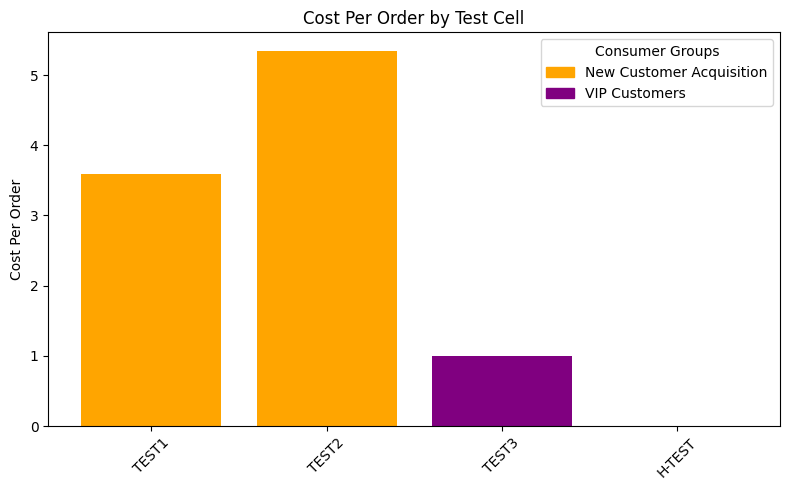

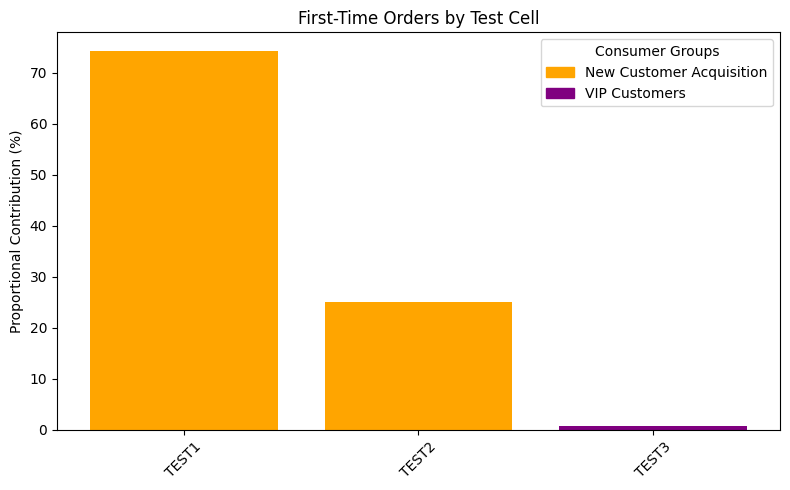

In [ ]:
## Compute KPIs: CPO and Breakout first time order
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

"""
GOAL: Compute KPI -- CPO and Breakout First Time Orders
    Note: 
    - CPO is the total cost divided by the number of orders (matches) for each test cell.

    - Breakout for TestCell_i = [( number of First-Time orders for test_i)/ total first time orders across all test cells)] 
        - Serves as a proportional contribution of each TestCell to the overall total of first-time orders. 

    - Proportional contribution of each test to first time orders: Breakout for TestCell_i * 100

    - Not meaningful to do Lift Over Holdout Metric for CPO because holdout CPO is 0, which would make any Lift calculation undefined. 
    - Not meaningful to do Lift Over Holdout Metric for Breakout because the holdout group does not contribute to first-time orders, making proportional comparisons irrelevant.

    Choices made: Convert 'FirstTimeOrder' to integer
       Because entries in 'FirstTimeOrder' column are binary values (1 for first-time orders, 0 for repeat orders), converting it to integers 
       makes it easy to sum how many first time orders there are for each test cell. 

"""


##### COST PER ORDER ###############

matches_per_testcell_mail = matches_mail['TestCell'].value_counts().to_dict()
matches_per_testcell_holdout = matches_holdout['TestCell'].value_counts().to_dict()
test_cells = ['TEST1', 'TEST2', 'TEST3', 'H-TEST' ]
total_costs = {}
cpo = {}

for i, cell in enumerate(test_cells):
    total_costs[cell] = mailplan_df['Total_Cost'].iloc[i]


for cell in test_cells:
    if cell in ['TEST1', 'TEST2', 'TEST3']:  # This is for the mail file
        total_cost = total_costs.get(cell, 0)
        match_count = matches_per_testcell_mail.get(cell, 0)
    else:  # This is for the holdout file (H-TEST)
        total_cost = total_costs.get(cell, 0)
        match_count = matches_per_testcell_holdout.get(cell, 0)
    
    # Calculate CPO
    if match_count > 0:
        cpo[cell] = total_cost / match_count
    else:
        cpo[cell] = 0  # If no matches, set CPO to 0

# Print the CPO for each test cell
for cell, cost in cpo.items():
    print(f"CPO for {cell}: {cost}")



#################### Break-out first time orders ######

merged_mailfile_and_cleaned_transactions = mailfile_df.merge(
    cleaned_transactions_csv[['FullAddress', 'FirstTimeOrder']],  
    on='FullAddress',
    how='inner'
)


merged_mailfile_and_cleaned_transactions['FirstTimeOrder'] = merged_mailfile_and_cleaned_transactions['FirstTimeOrder'].astype(int)

matched_first_time_orders_per_cell = merged_mailfile_and_cleaned_transactions.groupby('TestCell')['FirstTimeOrder'].sum() # Group by 'TestCell' and sum the 'FirstTimeOrder' for each test cell
first_time_orders_dict = matched_first_time_orders_per_cell.to_dict()

test_cells = ['TEST1', 'TEST2', 'TEST3']


firstime = {cell: first_time_orders_dict.get(cell, 0) for cell in test_cells} # Retrieve first-time orders for each test cell

firsttime_overall = sum(firstime.values()) # get overall number of first time orders across all test cells

print(f"Total First-Time Orders: {firsttime_overall}")

# Calculate proportional contribution
breakout_rate = {
    cell: (firstime[cell] / firsttime_overall) * 100 if firsttime_overall else 0
    for cell in test_cells
}

# Print
for cell, order in firstime.items():
    print(f"First-Time Orders for {cell}: {order}")
for cell, rate in breakout_rate.items():
    print(f"Proportional Contribution of {cell}: {rate}%")

##### first time for new acquisitions

firsttime_newcustomer = sum(list(firstime.values())[:2])  # Sum of the first two items
print(firsttime_newcustomer)

# Calculate proportional contribution
breakout_rate_newgroup = {
    cell: (firstime[cell] / firsttime_newcustomer) * 100 if firsttime_overall else 0
    for cell in test_cells
}
for cell, rate in list(breakout_rate_newgroup.items())[:2]:  
    print(f"New Customers Proportional Contribution of {cell}: {rate}%")

#################### CPO BAR GRAPH ######


cpo_cells = list(cpo.keys())
cpo_values = list(cpo.values())


color_mapping = {
    'orange': 'New Customer Acquisition',
    'purple': 'VIP Customers'
}



colors = ['orange', 'orange', 'purple']

plt.figure(figsize=(8, 5))
bars = plt.bar(cpo_cells, cpo_values, color=colors)

legend_patches = [
    mpatches.Patch(color='orange', label='New Customer Acquisition'),
    mpatches.Patch(color='purple', label='VIP Customers')
]


plt.legend(handles=legend_patches, title="Consumer Groups", loc="upper right", frameon=True)

plt.ylabel("Cost Per Order")
plt.title("Cost Per Order by Test Cell")
plt.xticks(rotation=45)
plt.tight_layout()


plt.savefig('cost_per_order.png')
plt.show()

#################### BREAKOUT FIRST-TIME ORDERS BAR GRAPH ######

breakout_cells = list(breakout_rate.keys())
breakout_values = list(breakout_rate.values())

color_mapping = {
    'orange': 'New Customer Acquisition',
    'purple': 'VIP Customers'
}

colors = ['orange', 'orange', 'purple']

plt.figure(figsize=(8, 5))
bars = plt.bar(breakout_cells, breakout_values, color=colors)

legend_patches = [
    mpatches.Patch(color='orange', label='New Customer Acquisition'),
    mpatches.Patch(color='purple', label='VIP Customers')
]

plt.legend(handles=legend_patches, title="Consumer Groups", loc="upper right", frameon=True)

plt.ylabel("Proportional Contribution (%)")
plt.title("First-Time Orders by Test Cell")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('breakout_firstorders.png')
plt.show()




5. For the test cells targeted for New Customer Acquisition, which one do you think is "best" when ignoring the holdout group's performance? Which test cell is "best" when factoring in the holdout? Is the answer still the same? Why or why not?

Answer: 
    (Ignoring Holdout group): TEST1 severely outperforms TEST2 when looking at the following Performance Indicators: Response Rate, CPO, Breakout First Time Orders, and Revenue: 
        1. Response Rate: TEST1 has a response rate of 27.37%, significantly higher than TEST2’s 12.24%. This indicates that a larger proportion of customers responded to TEST1, highlighting a stronger preference for the campaign in TEST1.

        2. CPO: TEST1 has a CPO of 3.59, compared to TEST2’s higher CPO of 5.34. A lower CPO indicates that TEST1 is more cost-effective, providing a better return on investment for each order generated.
        
        3. Breakout First-Time Orders: This indicator measures the proportional contribution of a test to the overall amount of first-time orders (across all tests). When comparing TEST1 and TEST2, we can see that TEST1 contributed significantly more to first-time orders than TEST2 (~74% to ~25%). Additionally, when I normalize the data to include only tests related to new customer acquisition (excluding first-time orders from TEST3), the proportional contributions of TEST1 and TEST2 remain nearly unchanged. TEST1 accounts for approximately 74.97%, while TEST2 contributes 25.24%, reinforcing TEST1’s dominance within the new customer segment.

        4. Revenue: TEST1 generates $506.50 per order, while TEST2 generates $480.18 per order. Not only is TEST1 more cost-effective (lower CPO), but it also brings in more revenue per order. This combination of higher revenue and lower cost makes TEST1 the best choice for maximizing campaign profitability.
    

    (Factoring in Holdout group): 
    When factoring in the holdout group (H-TEST) as the control group, we evaluate how TEST1 and TEST2 perform in comparison to the control, which represents a baseline scenario where no direct mail campaign is applied. Here’s how TEST1 and TEST2 stack up:
        
        1. Lift Over Holdout: TEST1 shows a lift of 31.67% over the holdout group, which means that TEST1 generated 31.67% more orders than the control group (H-TEST), highlighting its effectiveness in driving orders relative to no intervention. TEST2, on the other hand, has a negative lift of -41.10%, indicating that TEST2 underperformed compared to the control group. This suggests that the direct mail campaign in TEST2 either had no impact or resulted in fewer orders than if no campaign had been conducted.

        
        2. Revenue:  
        H-TEST (Control Group): Revenue per order: $508.11
          Although H-TEST had a higher revenue per order than the experimental groups, it's important to note that this group did not receive any mailing; this figure reflects natural order behavior without any campaign intervention. In order to see how much each test cell would have earned if it had received the same number of mailings as the holdout group, we compute and compare the adjusted revenue per order and total revenue.

          TEST1: Adjusted Revenue per order: is ~$229.81 / Adjusted Total Revenue: $530,639.9944338386,
        
          TEST2: Adjusted Revenue per order: is ~$290.85/ Adjusted Total Revenue  $671,584.2016525525,

          Important to note that:  TEST1 generated less revenue per order and total revenue when adjusted for holdout, but not horrifically.

        TEST1 versus TEST2:
          
          The answer changes. TEST1 is still effective in generating orders and revenue, but TEST2's negative lift relative to the holdout group makes it less effective when compared to TEST1. Even though TEST2 has a higher adjusted revenue per order and total revenue, its overall performance compared to the control group (H-TEST) suggests that it may not be as successful in driving profitable behavior.

            1. If driving up revenue is the focus of the client, then you would choose TEST2 over TEST1. If the goal is maximizing overall order volume: then TEST1's Lift results shows it is more effective at generating orders compared to no intervention (H-TEST) and/or TEST 2. 

            2. If the goal is maximizing return on investment (ROI): TEST1 has a lower CPO compared to TEST2, so it is more cost-effective. 

            3. If the goal is customer acquisition: TEST1 had a stronger contribution in first-time orders for customers than TEST 2, so TEST 1 is the better option.
            
            In conclusion, TEST1 is still the better option. 

        

6. After reading these results, the client notices the "perfect" performance for Test Cell 3. They determined that since Test Cell 3 used a Foldout format, we should only mail Foldouts going forward. Do you agree?

    Answer: 
        I do not agree that we should only mail Foldouts moving forward because of how Test Cell 3 performed. The biggest issues with this belief are:

            6a. Different Target Audience:
              Test Cell 3 focused on a completely different type of customer (VIP) compared to TEST1, TEST2, and H-TEST, which all focused on new customer acquisition. The results from Test Cell 3 might not be applicable to the other groups because the customer type targeted is not the same.
            
            6b. Small Sample Size:
              Test Cell 3 only had 12 matches, which is significantly less than the peer testing campaigns. In that regard, it would be imprudent to change an entire marketing strategy based on the results of such a small sample. A larger sample is needed to make more reliable conclusions.
            



7. The client wants to plan a second mailing campaign, using these results as an aid. What are your recommendations to the client on what they should do? Be precise, in one to three sentences.

Answer:
    
    1. Enhance Customer Targeting: Gather more customer demographic data to refine marketing campaigns and ensure they reach the most promising new customers—those most likely to convert.

    2. Prioritize TEST1’s Strategy: Given its superior performance— highest response rate, lowest CPO, and order volume—the client should adopt the approach used in TEST1 for future campaigns.

    3. Expand Foldout Testing for VIPs: Increase the sample size of VIP customers receiving foldouts to ensure statistically significant results. This will help determine whether TEST3’s high performance was an anomaly due to its small sample size or if foldouts are genuinely effective for this customer segment.





8. Conceptually:
    8a. What types of additional data might you want to build a model? 
    
    8b. What types of modeling techniques come to mind as having potential?
    
    8c. What programs and/or software do you think might be applicable or relevant to actually run a model? 
    
    8d. How would you approach working with datasets containing thousands of records versus datasets containing millions?

Answer for 8a:
    
    The desired additional data is dependent on the type of model the analysis team would be looking to build. However, certain datasets are universally valuable across various modeling approaches, which include the following: 
       
        - Customer Demographic Data (Age/Income/Location/Education/etc): This is always useful because it provides personal insights into the consumer base, which is critical for modeling ranging in customber behavour to benchmarking analysis. 

        - Customer Engagement Data (Previous purchasing behaviour/ Engagement with prior campaigns/ purchases before and after the campaign): This data can be naturally structured as time series data, which is crucial to analyzing customer behaviour as it changes over time. 

        - External Behaviour (Competitor Behaviour/ Product Pricing/ Seasonal economic trends): Understanding how external factors influence customer decisions is crucial for optimizing pricing and timing in promotional campaigns. This data provides insight into market purchasing behaviors, helping businesses determine what is in demand and what may be undersupplied.

Answer for 8b (What types of modeling techniques come to mind as having potential?):
    "Calls to Action" (CTAs) are a powerful tool in customer conversion because they guide users through the marketing funnel. However, each customer is on a unique journey. Thus, if businesses want to deliver highly personalized campaigns, then they must account for multiple marketing funnels, which is often impractical and cost-prohibitive, especially at scale.
    
    Effective customer segmentation strategies are essential. One potential modeling approach is clustering, which can identify distinct customer groups based on behavior, past purchases, engagement history, and other factors. By grouping similar customers together, businesses can tailor their marketing strategies more effectively—offering targeted CTAs that resonate with each segment while maintaining efficiency.
        - Clustering models:
        * "K-Means," is a clustering algorithm that partitions datapoints into a fixed number of groups based on a "similarity." Example: this would be useful for grouping customers based on behaviours such as purchase frequency in order to improve loyalty programs.

        * "Hierachical Clustering," is a clustering algorithm that creates a tree-like structure to show relationships between customers without predefined number of clusters beforehand. Example: this would be useful for understanding the different tiers of customers by using their order history to separate them into tiers such as highly-engaged, engaged, and not engaged. After this seperation, can really customize different mailing strategies. 
     
        * "DBSCAN," This algorithm identifies clusters based on the density of data points, useful for finding groups with varying densities. Example: this would be helpful for detecting outliers i.e. customers with unique purchasing behaviours. 


Answer for 8c. What programs and/or software do you think might be applicable or relevant to actually run a model? 
    To run the algorithms I discussed in the last question, the following programming languages and associated libraries work:
        * Python and scikit-learn
        * R and hclust/dbscan/stats(kmeans).
    To visualize the results, the following libraries and packages work for Python and R:
        * Python: Pandas/Numpy/matplotlib
        * R: ggplot2

    In general, the type of programs and software that would be relevant for running a model is dependent on the type of model. In every case, some type of software for running and writing code (ex: Jupyter Notebook) and dealing with dependencies from various packages (ex: Anaconda) would be useful. 

Answer for 8d. How would you approach working with datasets containing thousands of records versus datasets containing millions?

    The key issue that arises when working with datasets containing millions of records instead of thousands is complexity. Computationally, there might not be enough memory or processing power to execute every algorithm or touch every data point. In these cases, the following problem solving techniques are appropiate:

        - Algorithm Design and parallelization: To avoid immobilizing one person's computer, try to distribute compution over multiple processors or cloud computing system. Additionally, focus on creating scripts where the asymptotic groth rate of functions is not polynomial or exponential. 

        - Feature Selection: To avoid overfitting, try to reduce dimensionality of dataset through some predecided filtered structure. This also helps reduce computational complexity 

        - Sampling: To avoid working with the whole dataset, try to create a representative subset of the data through random or stratified sampling techniques. Alternative, work with a small sample of the data when working through bottlenecks. 
        



In [ ]:

matches_mail = pd.read_csv('matches_mail.csv')
matches_holdout = pd.read_csv('matches_holdout.csv')

def process_order_data(df_1, df_2):
   
   # total order count per state
    mail_matches_order_counts = df_1['State'].value_counts().reset_index()
    mail_matches_order_counts.columns = ['State', 'Total Orders']

    mail_holdout_order_counts = df_2['State'].value_counts().reset_index()
    mail_holdout_order_counts.columns = ['State', 'Total Orders']

    # order counts for each test type by state
    mail_test_type_counts = df_1.groupby(['State', 'TestCell']).size().unstack(fill_value=0)
    holdout_test_type_counts = df_2.groupby(['State', 'TestCell']).size().unstack(fill_value=0)

    # merge the total orders with the test type counts
    mail_matches_merged_counts = mail_matches_order_counts.set_index('State').join(mail_test_type_counts, on='State')
    holdout_matches_merged_counts = mail_holdout_order_counts.set_index('State').join(holdout_test_type_counts, on='State')

    # reset index to make dataframe
    mail_matches_merged_counts = mail_matches_merged_counts.reset_index()
    holdout_matches_merged_counts = holdout_matches_merged_counts.reset_index()


    mail_matches_merged_counts.to_csv('mail_matches_merged_counts.csv', index=False)
    holdout_matches_merged_counts.to_csv('holdout_matches_merged_counts.csv', index=False)

    return mail_matches_merged_counts, holdout_matches_merged_counts

mail_matches_merged_counts, holdout_matches_merged_counts = process_order_data(matches_mail, matches_holdout)

print(mail_matches_merged_counts)
print(holdout_matches_merged_counts)

















   State  Total Orders  TEST1  TEST2  TEST3
0     WI            61     46     15      0
1     AR            50     38     12      0
2     NJ            49     38     11      0
3     TN            46     35     11      0
4     WV            46     37      9      0
5     IN            46     36      8      2
6     OK            46     37      9      0
7     PA            45     31     13      1
8     MD            43     26     16      1
9     AZ            42     30     12      0
10    IL            42     33      8      1
11    LA            41     29     12      0
12    UT            41     31     10      0
13    MA            41     30     11      0
14    MN            40     29     11      0
15    ID            40     29     11      0
16    VA            40     27     13      0
17    HI            39     29     10      0
18    NC            38     30      8      0
19    MT            38     30      8      0
20    ND            37     27     10      0
21    OH            37     27   

In [ ]:

import geopandas as gpd
import matplotlib.pyplot as plt
import folium


shapefile_path = "gz_2010_us_040_00_5m.shp"
gdf_mail = gpd.read_file(shapefile_path)
gdf_holdout = gpd.read_file(shapefile_path)




order_data_mail = pd.read_csv("mail_matches_merged_counts.csv")
order_data_holdout = pd.read_csv("holdout_matches_merged_counts.csv")
state_abbr_to_name = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California", 
    "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia", 
    "HI": "Hawaii", "ID": "Idaho", "IL": "Illinois", "IN": "Indiana", "IA": "Iowa", 
    "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland", 
    "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi", "MO": "Missouri", 
    "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire", "NJ": "New Jersey", 
    "NM": "New Mexico", "NY": "New York", "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio", 
    "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania", "RI": "Rhode Island", "SC": "South Carolina", 
    "SD": "South Dakota", "TN": "Tennessee", "TX": "Texas", "UT": "Utah", "VT": "Vermont", 
    "VA": "Virginia", "WA": "Washington", "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming",
    "DC": "District of Columbia"  
}


order_data_mail['State'] = order_data_mail['State'].map(state_abbr_to_name)
order_data_holdout['State'] = order_data_holdout['State'].map(state_abbr_to_name)

# Check if the mapping worked
#print(order_data.head())

gdf_mail = gdf_mail.merge(order_data_mail, how="left", left_on="NAME", right_on="State")  

gdf_holdout = gdf_holdout.merge(order_data_holdout, how="left", left_on="NAME", right_on="State") 


gdf_mail.to_file("updated_us_states_with_orders_GDF_MAIL.shp", index=False)  
gdf_holdout.to_file("updated_us_states_with_orders_GDF_holdout.shp", index=False)  



/var/folders/g9/p7bhklf17q167l6fw7_tvhq40000gp/T/ipykernel_1918/1856105150.py:47: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_mail.to_file("/Users/emariedelanuez/Downloads/data-analyst-take-home/updated_us_states_with_orders_GDF_MAIL.shp")  # Save as shapefile
/var/folders/g9/p7bhklf17q167l6fw7_tvhq40000gp/T/ipykernel_1918/1856105150.py:48: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_holdout.to_file("/Users/emariedelanuez/Downloads/data-analyst-take-home/updated_us_states_with_orders_GDF_holdout.shp")  # Save as shapefile
